In [25]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [26]:
import sys
import paths
from pathlib2 import Path

sys.path.append(paths.PATH_TO_REPO.as_posix())

In [27]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["font.size"] = 14

In [29]:
import load_surfaces, training, dplot, utils, paths
from importlib import reload

def RELOAD():
    reload(load_surfaces)
    reload(training)
    reload(dplot)
    reload(utils)
    reload(paths)
    
RELOAD()

### Choose which data to load: old or new

In [32]:
TYPE = "new"
assert TYPE in ["old", "new"]

In [33]:
paths.PATH_TO_REPO.as_posix()

'/home/alexander/nn_stochvol'

In [41]:
paths.PATH_TO_NEW_DATA.as_posix()

'/home/alexander/nn_stochvol/r_code_for_sym/data'

In [44]:
ls /home/alexander/nn_stochvol/r_code_for_sym/data

20130814.csv                heston_params.csv         volsurfaces_with_bug/
forward_var_curves.csv      maturity_strike_grid.csv
forward_var_params_new.csv  volsurfaces/


In [47]:
if TYPE == "old":
    raw_data = load_surfaces.load_old_vlt_surfaces("TrainrBergomiTermStructure.txt.gz")
else:
    raw_data = load_surfaces.load_new_vlt_surfaces()

raw_data.keys()

Loading 53354 surfaces...


dict_keys(['params_nk', 'vols_nms', 'params_cols_k', 'mat_ms', 'strikes_ms'])

In [48]:
normalized_data = utils.get_train_test_split_nk_nf(raw_data)

normalized_data.keys()

dict_keys(['params_train_nk', 'vol_train_nf', 'params_test_Nk', 'vol_test_Nf', 'params_scaler', 'vol_scaler'])

In [49]:
torch_data = training.get_train_test_dataset_and_loader(normalized_data, batch_size=512)

### Define model and fit

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
model = training.get_torch_model(raw_data["params_nk"].shape[1], num_layers=4)

In [52]:
learner = training.Learner(model, torch_data["train_loader"], torch_data["test_loader"])

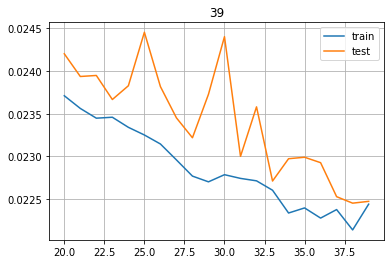

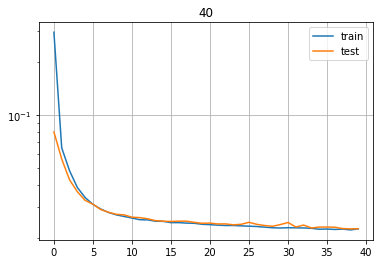

In [53]:
learner.train(40)

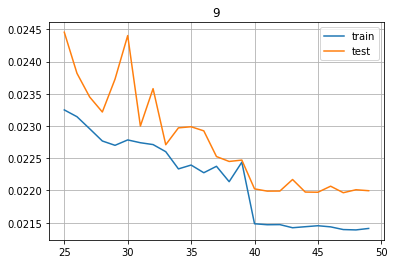

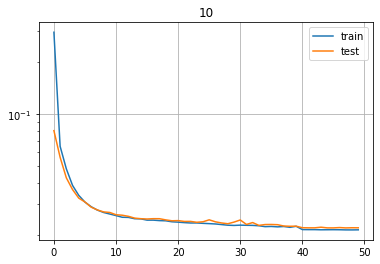

In [54]:
learner.optimizer.param_groups[0]["lr"] *= 0.1
learner.train(10)

### Save the model

In [55]:
paths.PATH_TO_MODELS.mkdir(exist_ok=True)

learner.model.eval()
torch.save(learner.model, str(paths.PATH_TO_MODELS/f"model_{TYPE}.pt"))

/home/alexander/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/alexander/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/alexander/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ELU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [56]:
model = torch.load(str(paths.PATH_TO_MODELS/f"model_{TYPE}.pt"))
learner = training.Learner(model, torch_data["train_loader"], torch_data["test_loader"])

### Plot errors

In [57]:
def calculate_errors(learner, torch_data, normalized_data):
    pred_surf_nms, target_surf_nms =\
        learner.predict(torch_data["test_dataset"], normalized_data["vol_scaler"])

    mse_ms = np.sqrt(((pred_surf_nms - target_surf_nms)**2).mean(axis=0))
    mse_ms /= target_surf_nms.mean(axis=0)
    return mse_ms
    
def plot_errors(mse_ms, raw_data, TYPE=TYPE):
    fig, axis = plt.subplots(1,1)
    axis.set_title(f"average relative error ({TYPE})")

    axis.set_yticks(np.arange(8))
    axis.set_xticks(np.arange(11))
    img = axis.imshow(mse_ms[::-1])

    axis.set_ylabel("maturity in years")
    axis.set_yticklabels(np.around(raw_data["mat_ms"][::-1, 0], 3))
    axis.set_xlabel(f"log strike at {raw_data['mat_ms'][3, 0] :.3f} years")
    axis.set_xticklabels(
        np.around(np.log(raw_data["strikes_ms"][3, :]), 3),
        rotation=30, ha="right")

    fig.colorbar(img)

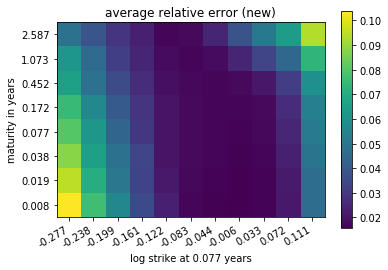

In [58]:
mse_ms = calculate_errors(learner, torch_data, normalized_data)
plot_errors(mse_ms, raw_data, TYPE)

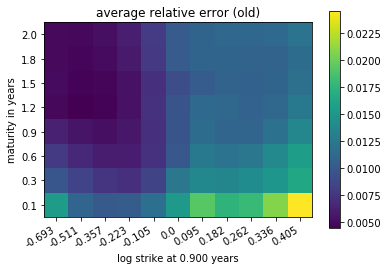

In [29]:
mse_ms = calculate_errors(learner, torch_data, normalized_data)
plot_errors(mse_ms, raw_data, TYPE)

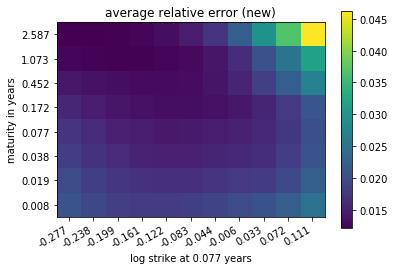

In [42]:
mse_ms = calculate_errors(learner, torch_data, normalized_data)
plot_errors(mse_ms, raw_data, TYPE)